In [1]:
import example
import numpy as np
import h5py
import matplotlib.pyplot as plt
import dexml
from dexml import fields
import lxml.etree as etree

f = raw_input("Give name of the XML File to load settings :") 

class record(dexml.Model):
	name = fields.String(tagname="name")
	interval = fields.Float(tagname="interval")
	row_index = fields.Integer(tagname="row_index")
	col_index = fields.Integer(tagname="col_index")

class settings(dexml.Model):
	total_time = fields.Float(tagname="total_time")
	timestep = fields.Float(tagname="timestep")
	records = fields.List(record)

#parse XML File
tree = etree.parse(f)
xmlstr = etree.tostring(tree, encoding='utf8', method='xml', pretty_print = True)
s = settings.parse(xmlstr)
print(s.total_time, s.timestep)

Give name of the XML File to load settings :settings.xml
(100.0, 1.0)


In [2]:
#create vector of Records
nr = len(s.records)
rec = example.RecordVector(nr)
for x in range (0,nr):
	print("Record :")
	rec[x].set_rec_name(str(s.records[x].name))
	rec[x].set_rec_interval(s.records[x].interval)
	rec[x].set_rec_row_index(s.records[x].row_index)
	rec[x].set_rec_col_index(s.records[x].col_index)

Give number of Records :1
Record :
name :rec1
interval :150
row index :1
column index :1


In [3]:
#create vector of Materials
n = int(raw_input("Give number of Materials :"))
mv = example.MaterialVector(n)
for x in range (0,n):
	print("Material ",x+1," :")
	mv[x].set_m_name(raw_input("name :"))
	mv[x].set_m_epsilon_r(float(raw_input("epsilon r :")))
	mv[x].set_m_mu_r(float(raw_input("mu r :")))
	mv[x].set_m_sigma(float(raw_input("sigma :")))

Give number of Materials :2
('Material ', 1, ' :')
name :vaccuum
epsilon r :1
mu r :2
sigma :3
('Material ', 2, ' :')
name :active region
epsilon r :4
mu r :5
sigma :6


In [4]:
#create vector of Regions
n = int(raw_input("Give number of Regions :"))
rv = example.RegionVector(n)
for x in range (0,n):
	print("Region ",x+1," :")
	rv[x].set_reg_name(raw_input("name :"))
	rv[x].set_reg_x_start(float(raw_input("start :")))
	rv[x].set_reg_x_end(float(raw_input("end :")))
	rv[x].set_reg_material_index(int(raw_input("material index :")))

Give number of Regions :3
('Region ', 1, ' :')
name :reg1
start :0
end :50
material index :1
('Region ', 2, ' :')
name :reg2
start :50
end :100
material index :2
('Region ', 3, ' :')
name :reg3
start :100
end :150
material index :1


In [5]:
#create Device
dev = example.Device()
dev.set_d_name(raw_input("Give name of the Device :"))
dev.set_d_materials(mv)
dev.set_d_regions(rv)

Give name of the Device :device


<example.RegionVector; proxy of <Swig Object of type 'std::vector< Region > *' at 0x7fb8925c3870> >

In [6]:
#create instance of Scenario
print("Scenario :")
scen = example.Scenario()
scen.set_s_name(raw_input("name :"))
scen.set_s_total_time(s.total_time)
scen.set_s_timestep(s.timestep)
scen.set_s_records(rec)

Scenario :
name :scenario


<example.RecordVector; proxy of <Swig Object of type 'std::vector< Record > *' at 0x7fb8925c3c60> >

In [7]:
#create Results
t = np.linspace(0,s.total_time,s.total_time/s.timestep)
print(len(t))
result = example.simul(dev, scen)
for x in range (0,nr):
	result[x].name = raw_input("Give name of the Result :")
	print(len(np.array(result[x].get_r_data())))

100
Give name of the Result :Population of first level
100


In [8]:
#save in hdf5 File
with h5py.File("f.h5", "w") as hdf:
	resultat = hdf.create_group('Resultat')	
	for x in range (0,nr):
		dataset = resultat.create_dataset("data", data = np.array(result[x].get_r_data()), compression = 'gzip', compression_opts = 9)
		dataset.attrs["name"] = result[x].get_r_name()
	resultat.attrs["total time"] = s.total_time
	resultat.attrs["time step"] = s.timestep

In [9]:
#load from hdf5 File
with h5py.File("f.h5", "r") as hdf:
	print("List of datasets in this file : ")
	r = hdf.get('Resultat')	
	for i in r.keys():
		print(i)
	data = r.get("data")
	dataset1 = np.array(data)
	print('Metadata : ')
	print(list(r.attrs.keys()))
	print(list(r.attrs.values()))

List of datasets in this file : 
data
Metadata : 
[u'total time', u'time step']
[100.0, 1.0]


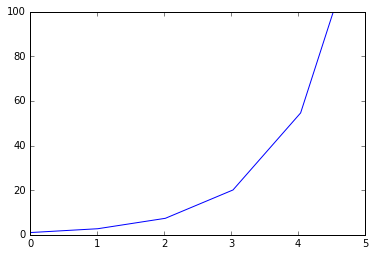

In [10]:
#plot results
for x in range (0,nr):
	plt.plot(t,np.array(result[x].get_r_data()))
	plt.axis([0,5,0,100])
	plt.show()